In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geodatasets as gds
import warnings

In [4]:
# import warnings
warnings.filterwarnings("ignore")

In [5]:
def clean_dataframe(df:pd.DataFrame, drop_rate: float=0.5, verbose: bool = True) -> pd.DataFrame:
    if drop_rate < 0 or drop_rate > 1:
        raise ValueError('drop_rate must be between 0 and 1')
    shape = df.shape
    df = df[df.columns[df.isna().sum() / df.shape[0] <= drop_rate]]
    df = df[df.columns[df.nunique() != 1]]
    df.drop_duplicates(inplace=True)
    if verbose:
        print(f'Cleaned DataFrame shape: {df.shape}')
        print(f'{shape[0] - df.shape[0]} rows were dropped')
        print(f'{shape[1] - df.shape[1]} columns were dropped')
    return df

In [7]:
df_kenya_birds1_raw = pd.read_csv('./data/simple/simple.csv', sep='\t')
df_kenya_birds1 = clean_dataframe(df_kenya_birds1_raw)
print(df_kenya_birds1.columns)
df_kenya_birds1

Cleaned DataFrame shape: (89632, 20)
0 rows were dropped
30 columns were dropped
Index(['gbifID', 'occurrenceID', 'order', 'family', 'genus', 'species',
       'taxonRank', 'scientificName', 'verbatimScientificName',
       'individualCount', 'decimalLatitude', 'decimalLongitude', 'eventDate',
       'day', 'month', 'year', 'taxonKey', 'speciesKey', 'lastInterpreted',
       'issue'],
      dtype='object')


,gbifID,occurrenceID,order,family,genus,species,taxonRank,scientificName,verbatimScientificName,individualCount,decimalLatitude,decimalLongitude,eventDate,day,month,year,taxonKey,speciesKey,lastInterpreted,issue
0,1986821111,d33e1483-ad6a-4aa2-95bd-5d4568a3cd3b,Passeriformes,Zosteropidae,Zosterops,Zosterops silvanus,SPECIES,"Zosterops silvanus J.L.Peters & Loveridge, 1935",Zosterops silvanus,1.0,-3.432285,38.341012,2017-11-09,9,11,2017,6100772,6100772.0,2024-03-21T12:54:52.894Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
1,1986821110,d12a2b54-f12a-40a7-bfb5-90b4998af7d3,Passeriformes,Zosteropidae,Zosterops,Zosterops senegalensis,SPECIES,"Zosterops senegalensis Bonaparte, 1850",Zosterops senegalensis,1.0,0.206000,34.884667,2017-06-01,1,6,2017,2489344,2489344.0,2024-03-21T12:54:54.972Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
2,1986821109,ff92601a-f8b9-4db0-90a1-e4d0b233ace0,Passeriformes,Zosteropidae,Zosterops,Zosterops senegalensis,SPECIES,"Zosterops senegalensis Bonaparte, 1850",Zosterops senegalensis,4.0,-0.558500,36.523667,2017-06-01,1,6,2017,2489344,2489344.0,2024-03-21T12:54:57.153Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
3,1986821108,a6bf4a1c-5c59-4a23-a18a-4ca9e6c36342,Passeriformes,Zosteropidae,Zosterops,Zosterops silvanus,SPECIES,"Zosterops silvanus J.L.Peters & Loveridge, 1935",Zosterops silvanus,1.0,-3.399601,38.329516,2017-10-06,6,10,2017,6100772,6100772.0,2024-03-21T12:55:11.136Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
4,1986821107,215c7fe0-9e39-4497-86b5-87532c478ef8,Passeriformes,Zosteropidae,Zosterops,Zosterops silvanus,SPECIES,"Zosterops silvanus J.L.Peters & Loveridge, 1935",Zosterops silvanus,1.0,-3.380438,38.353286,2017-10-06,6,10,2017,6100772,6100772.0,2024-03-21T12:54:51.116Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89627,1986731294,e49afe06-1ab4-410e-8971-186b5967b86b,Accipitriformes,Accipitridae,Accipiter,Accipiter badius,SPECIES,"Accipiter badius (Gmelin, 1788)",Accipiter badius,1.0,1.114823,37.460524,2018-01-13,13,1,2018,2480610,2480610.0,2024-03-21T12:54:56.058Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
89628,1986731293,82c2acec-5ed5-4b92-be62-2b43522a6f46,Accipitriformes,Accipitridae,Accipiter,Accipiter badius,SPECIES,"Accipiter badius (Gmelin, 1788)",Accipiter badius,1.0,1.010063,37.385208,2018-01-12,12,1,2018,2480610,2480610.0,2024-03-21T12:54:57.383Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
89629,1986731292,5da4a7c3-c2b9-4865-81b8-fb1f620ff070,Accipitriformes,Accipitridae,Accipiter,Accipiter melanoleucus,SPECIES,"Accipiter melanoleucus A.Smith, 1830",Accipiter melanoleucus,1.0,-3.991421,39.692136,2018-01-29,29,1,2018,2480631,2480631.0,2024-03-21T12:55:12.203Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
89630,1986731291,0d16b63d-2c88-43df-a45d-27c19f6e566c,Accipitriformes,Accipitridae,Accipiter,Accipiter badius,SPECIES,"Accipiter badius (Gmelin, 1788)",Accipiter badius,1.0,-3.415807,38.650147,2018-02-01,1,2,2018,2480610,2480610.0,2024-03-21T12:54:53.528Z,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...


In [9]:
df_kenya_birds2_raw = pd.read_csv('./data/species list/species_list.csv', sep='\t')
df_kenya_birds2 = clean_dataframe(df_kenya_birds2_raw)
print(df_kenya_birds2.columns)
df_kenya_birds2

Cleaned DataFrame shape: (1256, 16)
0 rows were dropped
6 columns were dropped
Index(['taxonKey', 'scientificName', 'acceptedTaxonKey',
       'acceptedScientificName', 'numberOfOccurrences', 'taxonRank',
       'taxonomicStatus', 'order', 'orderKey', 'family', 'familyKey', 'genus',
       'genusKey', 'species', 'speciesKey', 'iucnRedListCategory'],
      dtype='object')


,taxonKey,scientificName,acceptedTaxonKey,acceptedScientificName,numberOfOccurrences,taxonRank,taxonomicStatus,order,orderKey,family,familyKey,genus,genusKey,species,speciesKey,iucnRedListCategory
0,2492478,"Cercotrichas galactotes (Temminck, 1820)",5788860,"Erythropygia galactotes (Temminck, 1820)",33,SPECIES,SYNONYM,Passeriformes,729,Muscicapidae,9322,Erythropygia,4845640,Erythropygia galactotes,5788860.0,LC
1,2493976,"Dicrurus modestus Hartlaub, 1849",2493976,"Dicrurus modestus Hartlaub, 1849",42,SPECIES,ACCEPTED,Passeriformes,729,Dicruridae,9310,Dicrurus,2493960,Dicrurus modestus,2493976.0,LC
2,2494070,"Ploceus melanocephalus (Linnaeus, 1758)",2494070,"Ploceus melanocephalus (Linnaeus, 1758)",86,SPECIES,ACCEPTED,Passeriformes,729,Ploceidae,9336,Ploceus,2494008,Ploceus melanocephalus,2494070.0,LC
3,5230043,"Nectarinia hunteri (Shelley, 1889)",7340862,"Chalcomitra hunteri (Shelley, 1889)",2,SPECIES,SYNONYM,Passeriformes,729,Nectariniidae,5259,Chalcomitra,7340859,Chalcomitra hunteri,7340862.0,LC
4,5231347,"Bradypterus lopezi (Alexander, 1903)",5231347,"Bradypterus lopezi (Alexander, 1903)",13,SPECIES,ACCEPTED,Passeriformes,729,Locustellidae,6100825,Bradypterus,3242162,Bradypterus lopezi,5231347.0,LC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,2478792,"Stactolaema olivacea (Shelley, 1880)",2478792,"Stactolaema olivacea (Shelley, 1880)",31,SPECIES,ACCEPTED,Piciformes,724,Lybiidae,4849497,Stactolaema,2478791,Stactolaema olivacea,2478792.0,LC
1252,2484628,"Vidua macroura (Pallas, 1764)",2484628,"Vidua macroura (Pallas, 1764)",239,SPECIES,ACCEPTED,Passeriformes,729,Viduidae,5295,Vidua,2484612,Vidua macroura,2484628.0,LC
1253,2493594,"Lonchura fringilloides (Lafresnaye, 1835)",2493594,"Lonchura fringilloides (Lafresnaye, 1835)",2,SPECIES,ACCEPTED,Passeriformes,729,Estrildidae,5709,Lonchura,2493593,Lonchura fringilloides,2493594.0,LC
1254,5231303,"Sylvia lugens Rüppell, 1840",5231303,"Sylvia lugens Rüppell, 1840",65,SPECIES,ACCEPTED,Passeriformes,729,Sylviidae,5285,Sylvia,2492941,Sylvia lugens,5231303.0,LC


In [10]:
df_occurance_raw = pd.read_csv('./data/darwin core archive/occurrence.txt', sep='\t')
df_occurance = clean_dataframe(df_occurance_raw)
print(df_occurance.columns)
df_occurance

Cleaned DataFrame shape: (89632, 42)
0 rows were dropped
181 columns were dropped
Index(['gbifID', 'occurrenceID', 'individualCount', 'occurrenceRemarks',
       'eventDate', 'startDayOfYear', 'endDayOfYear', 'year', 'month', 'day',
       'decimalLatitude', 'decimalLongitude', 'scientificName', 'order',
       'family', 'genus', 'genericName', 'specificEpithet', 'taxonRank',
       'vernacularName', 'taxonomicStatus', 'lastInterpreted', 'issue',
       'taxonKey', 'acceptedTaxonKey', 'orderKey', 'familyKey', 'genusKey',
       'speciesKey', 'species', 'acceptedScientificName',
       'verbatimScientificName', 'lastParsed', 'level0Gid', 'level0Name',
       'level1Gid', 'level1Name', 'level2Gid', 'level2Name', 'level3Gid',
       'level3Name', 'iucnRedListCategory'],
      dtype='object')


,gbifID,occurrenceID,individualCount,occurrenceRemarks,eventDate,startDayOfYear,endDayOfYear,year,month,day,...,lastParsed,level0Gid,level0Name,level1Gid,level1Name,level2Gid,level2Name,level3Gid,level3Name,iucnRedListCategory
0,1986821111,d33e1483-ad6a-4aa2-95bd-5d4568a3cd3b,1.0,Endangered (EN),2017-11-09,313,313,2017,11,9,...,2024-03-21T12:54:52.894Z,KEN,Kenya,KEN.39_1,Taita Taveta,KEN.39.1_1,Mwatate,KEN.39.1.5_1,Wusi/Kishamba,EN
1,1986821110,d12a2b54-f12a-40a7-bfb5-90b4998af7d3,1.0,Least Concern (LC),2017-06-01,152,152,2017,6,1,...,2024-03-21T12:54:54.972Z,KEN,Kenya,KEN.11_1,Kakamega,KEN.11.11_1,Shinyalu,KEN.11.11.1_1,Isukha Central,LC
2,1986821109,ff92601a-f8b9-4db0-90a1-e4d0b233ace0,4.0,Least Concern (LC),2017-06-01,152,152,2017,6,1,...,2024-03-21T12:54:57.153Z,KEN,Kenya,KEN.35_1,Nyandarua,KEN.35.1_1,Kinangop,KEN.35.1.1_1,Engineer,LC
3,1986821108,a6bf4a1c-5c59-4a23-a18a-4ca9e6c36342,1.0,Endangered (EN),2017-10-06,279,279,2017,10,6,...,2024-03-21T12:55:11.136Z,KEN,Kenya,KEN.39_1,Taita Taveta,KEN.39.4_1,Wundanyi,KEN.39.4.4_1,Wundanyi/Mbale,EN
4,1986821107,215c7fe0-9e39-4497-86b5-87532c478ef8,1.0,Endangered (EN),2017-10-06,279,279,2017,10,6,...,2024-03-21T12:54:51.116Z,KEN,Kenya,KEN.39_1,Taita Taveta,KEN.39.4_1,Wundanyi,KEN.39.4.2_1,Werugha,EN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89627,1986731294,e49afe06-1ab4-410e-8971-186b5967b86b,1.0,Least Concern (LC),2018-01-13,13,13,2018,1,13,...,2024-03-21T12:54:56.058Z,KEN,Kenya,KEN.37_1,Samburu,KEN.37.1_1,Samburu East,KEN.37.1.1_1,Wamba East,LC
89628,1986731293,82c2acec-5ed5-4b92-be62-2b43522a6f46,1.0,Least Concern (LC),2018-01-12,12,12,2018,1,12,...,2024-03-21T12:54:57.383Z,KEN,Kenya,KEN.37_1,Samburu,KEN.37.1_1,Samburu East,KEN.37.1.1_1,Wamba East,LC
89629,1986731292,5da4a7c3-c2b9-4865-81b8-fb1f620ff070,1.0,Least Concern (LC),2018-01-29,29,29,2018,1,29,...,2024-03-21T12:55:12.203Z,KEN,Kenya,KEN.28_1,Mombasa,KEN.28.3_1,Kisauni,KEN.28.3.5_1,Mtopanga,LC
89630,1986731291,0d16b63d-2c88-43df-a45d-27c19f6e566c,1.0,Least Concern (LC),2018-02-01,32,32,2018,2,1,...,2024-03-21T12:54:53.528Z,KEN,Kenya,KEN.39_1,Taita Taveta,KEN.39.3_1,Voi,KEN.39.3.1_1,Kaloleni,LC


In [11]:
verbatim_raw = pd.read_csv('./data/darwin core archive/verbatim.txt', sep='\t')
verbatim = clean_dataframe(verbatim_raw)
print(verbatim.columns)
verbatim

Cleaned DataFrame shape: (89632, 14)
0 rows were dropped
176 columns were dropped
Index(['gbifID', 'occurrenceID', 'individualCount', 'occurrenceRemarks',
       'eventDate', 'decimalLatitude', 'decimalLongitude', 'scientificName',
       'class', 'order', 'family', 'genus', 'specificEpithet',
       'vernacularName'],
      dtype='object')


,gbifID,occurrenceID,individualCount,occurrenceRemarks,eventDate,decimalLatitude,decimalLongitude,scientificName,class,order,family,genus,specificEpithet,vernacularName
0,1986821111,d33e1483-ad6a-4aa2-95bd-5d4568a3cd3b,1.0,Endangered (EN),2017-11-09,-3.432285,38.341012,Zosterops silvanus,Aves,Passeriformes,Zosteropidae,Zosterops,silvanus,Taita White-eye
1,1986821110,d12a2b54-f12a-40a7-bfb5-90b4998af7d3,1.0,Least Concern (LC),2017-06-01,0.206000,34.884667,Zosterops senegalensis,Aves,Passeriformes,Zosteropidae,Zosterops,senegalensis,African Yellow White-eye
2,1986821109,ff92601a-f8b9-4db0-90a1-e4d0b233ace0,4.0,Least Concern (LC),2017-06-01,-0.558500,36.523667,Zosterops senegalensis,Aves,Passeriformes,Zosteropidae,Zosterops,senegalensis,African Yellow White-eye
3,1986821108,a6bf4a1c-5c59-4a23-a18a-4ca9e6c36342,1.0,Endangered (EN),2017-10-06,-3.399601,38.329516,Zosterops silvanus,Aves,Passeriformes,Zosteropidae,Zosterops,silvanus,Taita White-eye
4,1986821107,215c7fe0-9e39-4497-86b5-87532c478ef8,1.0,Endangered (EN),2017-10-06,-3.380438,38.353286,Zosterops silvanus,Aves,Passeriformes,Zosteropidae,Zosterops,silvanus,Taita White-eye
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89627,1986731294,e49afe06-1ab4-410e-8971-186b5967b86b,1.0,Least Concern (LC),2018-01-13,1.114823,37.460524,Accipiter badius,Aves,Accipitriformes,Accipitridae,Accipiter,badius,Shikra
89628,1986731293,82c2acec-5ed5-4b92-be62-2b43522a6f46,1.0,Least Concern (LC),2018-01-12,1.010063,37.385208,Accipiter badius,Aves,Accipitriformes,Accipitridae,Accipiter,badius,Shikra
89629,1986731292,5da4a7c3-c2b9-4865-81b8-fb1f620ff070,1.0,Least Concern (LC),2018-01-29,-3.991421,39.692136,Accipiter melanoleucus,Aves,Accipitriformes,Accipitridae,Accipiter,melanoleucus,Black Sparrowhawk
89630,1986731291,0d16b63d-2c88-43df-a45d-27c19f6e566c,1.0,Least Concern (LC),2018-02-01,-3.415807,38.650147,Accipiter badius,Aves,Accipitriformes,Accipitridae,Accipiter,badius,Shikra


In [13]:
df = df_kenya_birds1[['order', 'decimalLongitude', 'decimalLatitude', 'individualCount']]
print(df.isna().sum())
df.dropna(inplace=True)
df['order'].value_counts()

order                0
decimalLongitude     0
decimalLatitude      0
individualCount     80
dtype: int64


order
Passeriformes          49872
Pelecaniformes          5545
Accipitriformes         5439
Columbiformes           4943
Charadriiformes         3953
Coraciiformes           3111
Piciformes              2860
Bucerotiformes          1749
Coliiformes             1585
Cuculiformes            1426
Apodiformes             1361
Anseriformes            1261
Galliformes             1169
Ciconiiformes           1097
Gruiformes               852
Musophagiformes          741
Suliformes               485
Falconiformes            320
Otidiformes              318
Psittaciformes           312
Strigiformes             223
Podicipediformes         211
Caprimulgiformes         208
Struthioniformes         145
Phoenicopteriformes      145
Pteroclidiformes         124
Trogoniformes             92
Procellariiformes          5
Name: count, dtype: int64

In [23]:
df['individualCount'].sort_values(ascending=False)

26819    7000.0
26865    6600.0
27489    1800.0
27683    1490.0
62429    1000.0
          ...  
33344       1.0
33343       1.0
33342       1.0
33341       1.0
89631       1.0
Name: individualCount, Length: 89552, dtype: float64

<Axes: xlabel='individualCount', ylabel='Count'>

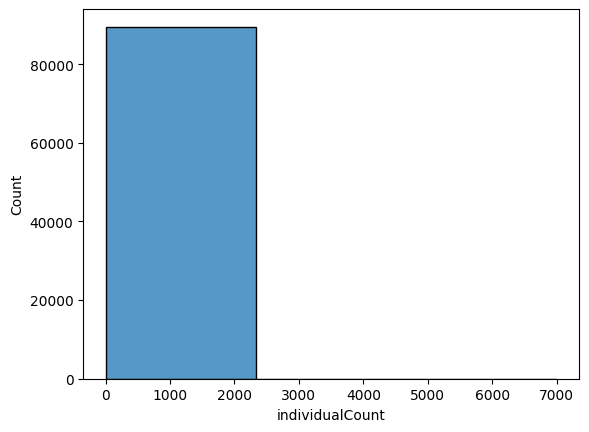

In [21]:
sns.histplot(df['individualCount'], bins=3)

In [27]:
min_lan = df['decimalLatitude'].min()
max_lan = df['decimalLatitude'].max()
min_lon = df['decimalLongitude'].min()
max_lon = df['decimalLongitude'].max()

In [30]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['decimalLongitude'], df['decimalLatitude']), crs='EPSG:4326')
world = gpd.read_file(gds.get_path('naturalearth.land'))

ax = world.clip(
    [5.0805, 33.2897, -4.6980, 41.8104]
).plot(color='white', edgecolor='black', figsize=(20, 20))
gdf.plot(ax=ax, color='red', markersize=10)
plt.show()

GEOSException: IllegalArgumentException: Clipping rectangle must be non-empty